# Google Trends

If we query from website from 2012 to 2023, Google trends will only give us monthly aggregated interest. So in order to get daily interest for 12 years, we need to get the monthly aggregated vaules as a scale first, then query for each month interval to get daily stats of that month.


To make valid inter-monthly comparisons between data points from different month ,
taggretatedall monthly interest number is used to adjust the data. E.g. if the da ly
interest of 1 Jan 2012 is 50 and the monthly interest of Jan 2012 across the 20 2 -
2023 window is 80, the daily interest of 1 Jan 2012 after adjustment will be 50* .8 
40.


In [53]:
# pip install pytrends OR
# conda install conda-forge::pytrends
# wiki: https://pypi.org/project/pytrends/

from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["Semiconductor"]
# get from 2012 to 2023 monthly interest
pytrends.build_payload(kw_list, cat=0, timeframe='2012-01-01 2023-12-30', geo='', gprop='')
monthly_all_data = pytrends.interest_over_time()
monthly_all_data.describe()

,Semiconductor
count,144.000000
mean,53.006944
std,12.900640
min,35.000000
25%,44.000000
50%,48.000000
75%,61.250000
max,100.000000


In [57]:
import pandas as pd
import numpy as np

def generate_month_ranges(start_year, end_year):
    dates = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-01", freq='MS')
    month_ranges = []
    for i in range(len(dates)):
        start_date = dates[i]
        end_date = start_date + pd.offsets.MonthEnd(0)
        month_ranges.append(f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}")
    return month_ranges

intervals = generate_month_ranges(2012, 2023)

daily_all_data = pd.DataFrame()
dfs = []

# get daily interest for each month
for i in range(144): # Jan 2012 to Dec 2023, 144 months in total
    interval = intervals[i]
    pytrends.build_payload(kw_list, cat=0, timeframe=interval, geo='', gprop='')
    month_data = pytrends.interest_over_time()
    month_data['Semiconductor'] = month_data['Semiconductor'] * monthly_all_data['Semiconductor'].iloc[i] / 100
    dfs.append(month_data)

daily_all_data = pd.concat(dfs, ignore_index=True)

daily_all_data.head()

,Semiconductor,isPartial
0,21.66,False
1,29.64,False
2,38.76,False
3,48.45,False
4,42.18,False


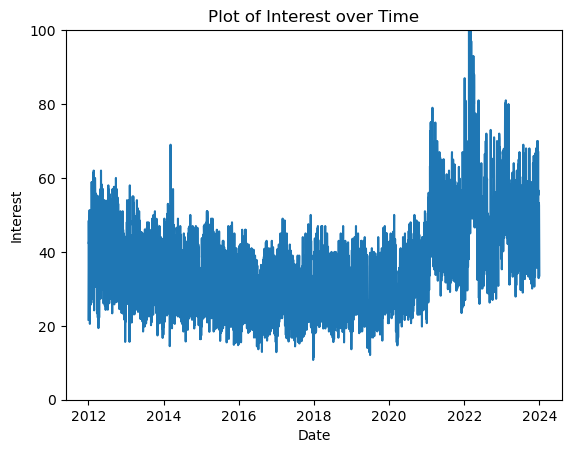

In [58]:
import matplotlib.pyplot as plt

# set index as dates
daily_all_data.index = pd.date_range(start='2012-01-01', periods=len(daily_all_data))
# plot the trends
plt.plot(daily_all_data.index, daily_all_data['Semiconductor'])
plt.ylim(0, 100)
# add labels and title
plt.xlabel('Date')
plt.ylabel('Interest')
plt.title('Plot of Interest over Time')
plt.show()

Text(0.5, 1.0, 'Plot of Interest over Time')

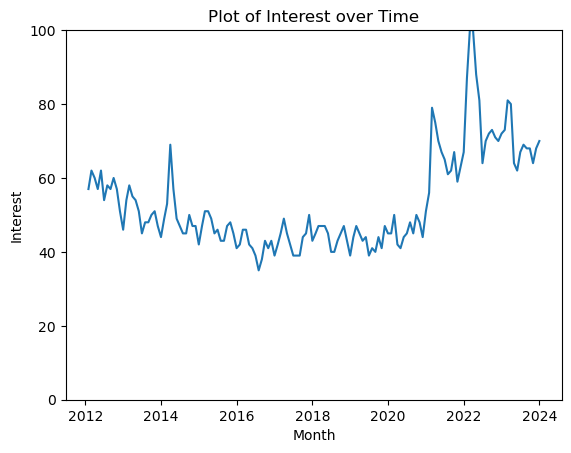

In [59]:
# to show it at month level:
interest_resampled = daily_all_data.resample('M').max()
plt.plot(interest_resampled.index, interest_resampled['Semiconductor'])
plt.ylim(0, 100)
plt.xlabel('Month')
plt.ylabel('Interest')
plt.title('Plot of Interest over Time')

The plot above can be verified on this link:

https://trends.google.com/trends/explore?date=2012-01-01%202023-12-31&q=semiconductor&hl=en-GB

In [61]:
# save down for future reference
daily_all_data.to_csv('google trend/daily_trends_2012_to_2023.csv')

# Collect relevant threads from Reddit

We scrapped all posts and comments under `r/Semiconductor` and `r/News_Semiconductor` subreddits created during 2012 - 2023 using Pushshift Reddit API:

https://github.com/pushshift/api

In [12]:
import zstandard
import os
import json
import sys
import csv
from datetime import datetime

input_file_path = r"reddit/subreddits23/Bitcoin_submissions.zst"
output_file_path = r"reddit/Bitcoin_submissions.csv"
# body for comments, title and selftext for submissions (posts)
fields = ["created","title","selftext"]

def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)

def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line, file_handle.tell()

            buffer = lines[-1]
        reader.close()

file_size = os.stat(input_file_path).st_size
file_lines, bad_lines = 0, 0
line, created = None, None
output_file = open(output_file_path, "w", encoding='utf-8', newline="")
writer = csv.writer(output_file)
writer.writerow(fields)
try:
    for line, file_bytes_processed in read_lines_zst(input_file_path):
        try:
            obj = json.loads(line)
            output_obj = []
            for field in fields:
                if field == "created":
                    value = datetime.fromtimestamp(int(obj['created_utc'])).strftime("%Y-%m-%d %H:%M")
                else:
                    value = obj[field]
                output_obj.append(str(value).encode("utf-8", errors='replace').decode())
            writer.writerow(output_obj)

            created = datetime.utcfromtimestamp(int(obj['created_utc']))
        except json.JSONDecodeError as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            print(f"{created.strftime('%Y-%m-%d %H:%M:%S')} : {file_lines:,} : {bad_lines:,} : {(file_bytes_processed / file_size) * 100:.0f}%")
except KeyError as err:
    print(f"Object has no key: {err}")
except Exception as err:
    print(err)
    
output_file.close()
print(f"Complete : {file_lines:,} : {bad_lines:,}")

2013-12-24 21:58:38 : 100,000 : 0 : 15%
2014-08-31 20:56:04 : 200,000 : 0 : 23%
2015-08-20 17:52:54 : 300,000 : 0 : 31%
2017-02-24 18:09:49 : 400,000 : 0 : 39%
2017-10-23 05:49:41 : 500,000 : 0 : 45%
2018-01-06 17:21:50 : 600,000 : 0 : 55%
2018-09-03 09:02:01 : 700,000 : 0 : 59%
2019-10-18 10:47:18 : 800,000 : 0 : 68%
2020-12-28 20:05:21 : 900,000 : 0 : 76%
2021-06-03 11:48:58 : 1,000,000 : 0 : 83%
2022-05-12 13:55:47 : 1,100,000 : 0 : 93%
2023-12-31 15:03:22 : 1,200,000 : 0 : 100%
Complete : 1,200,084 : 0


# Sentiment from Factiva

In [31]:
import pandas as pd
import numpy as np

file_path = r"factiva/Factiva semiconductor news collection 2012-2023 processed.txt"

titles = []
sources = []
dates = []
texts = []

with open(file_path, "r", encoding="utf-8") as file:
    while True:
        # Read the next 4 lines
        title = file.readline().strip()
        if not title:  # If end of file is reached
            break
        source_date = file.readline().strip()
        text = file.readline().strip()
        
        # Split source_date into source and date
        source, date_str = source_date.rsplit(", ", 1)
        
        # Append data to lists
        titles.append(title)
        sources.append(source)
        dates.append(pd.to_datetime(date_str))
        texts.append(text)
        
        # Skip the empty line
        file.readline()

df = pd.DataFrame({
    "date": dates,
    "source": sources,
    "title": titles,
    "text": texts
})

pd.set_option('display.max_colwidth', 45)
df.to_csv(r"factiva/Factiva_semiconductor_news_2012-2023.csv", index=False)
df.head()

,date,source,title,text
0,2012-01-01,Euromoney,Best managed companies in Asia 2012: Over...,Asia Best Managed Companies: Results inde...
1,2012-01-01,EUROTRADE Computer & Communication Magazine,Low Temperature Polysilicon and IGZO Prod...,"oxide), critical to production of the hig..."
2,2012-01-02,Dow Jones News Service,Global Chip Sales Drop Sequentially In No...,Sales of semiconductors fell in November ...
3,2012-01-03,Barron's Online,Stocks in the Spotlight Tuesday,Barclays analyst C.J. Muse upgraded Micro...
4,2012-01-03,Taipei Times,Cloud computing set to drive tech sector:...,Mobile devices with cloud computing capab...


**By now we should have all text corpus needed ready as csv files. Let's create embeddings for them.**

In [35]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

data = pd.read_csv("factiva/Factiva_semiconductor_news_2012-2023.csv", encoding="utf-8", na_values='')
data['title_text'] = data['title'] + ' ' + data['text']
data.head()

,date,source,title,text,title_text
0,2012-01-01,Euromoney,Best managed companies in Asia 2012: Over...,Asia Best Managed Companies: Results inde...,Best managed companies in Asia 2012: Over...
1,2012-01-01,EUROTRADE Computer & Communication Magazine,Low Temperature Polysilicon and IGZO Prod...,"oxide), critical to production of the hig...",Low Temperature Polysilicon and IGZO Prod...
2,2012-01-02,Dow Jones News Service,Global Chip Sales Drop Sequentially In No...,Sales of semiconductors fell in November ...,Global Chip Sales Drop Sequentially In No...
3,2012-01-03,Barron's Online,Stocks in the Spotlight Tuesday,Barclays analyst C.J. Muse upgraded Micro...,Stocks in the Spotlight Tuesday Barclays ...
4,2012-01-03,Taipei Times,Cloud computing set to drive tech sector:...,Mobile devices with cloud computing capab...,Cloud computing set to drive tech sector:...


In [37]:
# Load tokenizer and model from Hugging Face Hub
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for sentiment analysis
finbert_sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

financial_texts = data['title_text'].values

# Analyze the sentiment of each financial text
results = [(text, finbert_sentiment_pipeline(text)) for text in financial_texts]

for text, sentiment in results[:20]:
    print(f"Text: {text}\nSentiment: {sentiment}\n")

Text: Best managed companies in Asia 2012: Overall results Asia Best Managed Companies: Results index Overall Number of companies nominated: 171 2012 Company Score 1 China Telecom 16.51% 2 CNOOC
Sentiment: [{'label': 'Neutral', 'score': 0.9999110698699951}]

Text: Low Temperature Polysilicon and IGZO Production Forecast to Skyrocket 150% in 2012 oxide), critical to production of the high resolution displays used by these devices. These TFT technologies employ high mobility semiconductor materials, which allow panel manufacturers to shrink TFT dimensions and increase light transmission. LCDs with greater
Sentiment: [{'label': 'Neutral', 'score': 0.797595202922821}]

Text: Global Chip Sales Drop Sequentially In November -Xinhua Sales of semiconductors fell in November from the previous month due to the impacts of flooding in Thailand and the euro-zone crisis, according to theSemiconductorIndustry Association, Chinese news agency Xinhua reported Monday.
Sentiment: [{'label': 'Negative', '

In [46]:
labels = []
scores = []
for res in results:
    label = res[1][0]['label']
    score = res[1][0]['score']
    if label == 'Neutral':
        score = 0
    elif label == 'Positive':
        score = 1 * score
    elif label == 'Negative':
        score = -1 * score
    labels.append(label)
    scores.append(score)

# Create new columns in the DataFrame
data['label'] = labels
data['score'] = scores
data.to_csv(r"factiva/Factiva_sentiments_with_scores.csv", index=False)
data.head()

,date,source,title,text,title_text,label,score
0,2012-01-01,Euromoney,Best managed companies in Asia 2012: Over...,Asia Best Managed Companies: Results inde...,Best managed companies in Asia 2012: Over...,Neutral,0.000000
1,2012-01-01,EUROTRADE Computer & Communication Magazine,Low Temperature Polysilicon and IGZO Prod...,"oxide), critical to production of the hig...",Low Temperature Polysilicon and IGZO Prod...,Neutral,0.000000
2,2012-01-02,Dow Jones News Service,Global Chip Sales Drop Sequentially In No...,Sales of semiconductors fell in November ...,Global Chip Sales Drop Sequentially In No...,Negative,-1.000000
3,2012-01-03,Barron's Online,Stocks in the Spotlight Tuesday,Barclays analyst C.J. Muse upgraded Micro...,Stocks in the Spotlight Tuesday Barclays ...,Positive,0.999753
4,2012-01-03,Taipei Times,Cloud computing set to drive tech sector:...,Mobile devices with cloud computing capab...,Cloud computing set to drive tech sector:...,Positive,1.000000


In [79]:
# Group by date and calculate average score
data_sentiment_score = data.groupby('date')['score'].median().reset_index()

# Rename the columns for clarity
data_sentiment_score.columns = ['date', 'factiva_score']
data_sentiment_score['date'] = pd.to_datetime(data_sentiment_score['date'])

date_range = pd.date_range(start='2012-01-01', end='2023-12-31')

# Merge the all_dates_df with df_avg_score using left join to fill missing dates with score 0
data_sentiment_score = pd.merge(pd.DataFrame({'date': date_range}), data_sentiment_score, on='date', how='left')
data_sentiment_score['factiva_score'].fillna(0, inplace=True)

data_sentiment_score.index = date_range
data_sentiment_score.drop(columns=['date'], inplace=True)
data_sentiment_score.head()
# print(data_sentiment_score.index.nunique())
# print(data_sentiment_score.index.min())
# print(data_sentiment_score.index.max())

,factiva_score
2012-01-01,0.000000
2012-01-02,-1.000000
2012-01-03,0.999877
2012-01-04,0.000000
2012-01-05,0.000000


In [ ]:
daily_all_data.drop(columns=['isPartial'], inplace=True)
daily_all_data.columns = ['google_trend']

In [193]:
data_new_features = data_sentiment_score.join(daily_all_data, how='left')
data_new_features.head()

,factiva_score,google_trend
2012-01-01,0.000000,21.66
2012-01-02,-1.000000,29.64
2012-01-03,0.999877,38.76
2012-01-04,0.000000,48.45
2012-01-05,0.000000,42.18


# Sentiment from Reddit

In [178]:
import re

bitcoin_data = pd.read_csv("reddit/Bitcoin_submissions.csv", encoding="ISO-8859-1", na_values='')
bitcoin_data['created'] = pd.to_datetime(bitcoin_data['created'])
# sort and filter by date range
bitcoin_data = bitcoin_data.sort_values(by='created')[(bitcoin_data['created'] >= '2012-01-01') & (bitcoin_data['created'] <= '2023-12-31')].reset_index(drop=True)

# fill NaN (empty) text (posts with only a title)
bitcoin_data['selftext'].fillna('', inplace=True)

# keep only date part and rename column from "created" to "date"
bitcoin_data['date'] = bitcoin_data['created'].dt.date
bitcoin_data['date'] = pd.to_datetime(bitcoin_data['date'])
bitcoin_data.drop(columns=['created'], inplace=True)

# combine title and selftext (content) for sentiment analysis
bitcoin_data['combined_text'] = bitcoin_data['title'] + ' ' + bitcoin_data['selftext']
bitcoin_data.drop(columns=['title','selftext'], inplace=True)

# drop combined_text longer than 1000 characters
bitcoin_data = bitcoin_data[bitcoin_data['combined_text'].str.len() <= 1000]

# shrink our dataset, allowing max 10 records per date
def select_random_records(group):
    return group.sample(min(len(group), 10), random_state=2024)

bitcoin_data_shuffled = bitcoin_data.groupby('date', group_keys=False).apply(select_random_records).sort_values(by='date').reset_index(drop=True)

# Remove links and special characters from the text in each text
pattern = r'https?://\S+'
bitcoin_data_shuffled['combined_text'].replace(r'https?://\S+', '', regex=True, inplace=True)
bitcoin_data_shuffled['combined_text'].replace(r'[^A-Za-z0-9]+', ' ', regex=True, inplace=True)

bitcoin_data_shuffled

C:\Users\gong_\AppData\Local\Temp\ipykernel_13520\3631114010.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bitcoin_data = bitcoin_data.sort_values(by='created')[(bitcoin_data['created'] >= '2012-01-01') & (bitcoin_data['created'] <= '2023-12-31')].reset_index(drop=True)


,date,combined_text
0,2012-01-01,Bitcoin Finishes 2011 Up 1 473
1,2012-01-01,Bitcoin Media bulleted advantages
2,2012-01-01,This is why we need bitcoins
3,2012-01-01,When can the U S government order you to ...
4,2012-01-01,2011 Bitcoin Awards As discussed here nom...
...,...,...
43600,2023-12-30,If bitcoin goes to 1 million each what do...
43601,2023-12-30,Analyzing Bitcoin s Value The Impact of 7...
43602,2023-12-30,I created an A I trend forecasting tool f...
43603,2023-12-30,Top 5 Bitcoin Exchanges in Nigeria 2024 r...


In [180]:
# Save down the progress
bitcoin_data_shuffled.to_csv(r"reddit/reddit_bitcoin_sentiments.csv", index=False)

In [179]:
# Load tokenizer and model from Hugging Face Hub
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

bitcoin_texts = bitcoin_data_shuffled['combined_text'].values

# Create a pipeline for sentiment analysis
finbert_sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Analyze the sentiment of each financial text
btc_results = [(text, finbert_sentiment_pipeline(text)) for text in bitcoin_texts]

for text, sentiment in btc_results[:10]:
    print(f"Text: {text}\nSentiment: {sentiment}\n")

Text: Bitcoin Finishes 2011 Up 1 473 
Sentiment: [{'label': 'Neutral', 'score': 0.9692538380622864}]

Text: Bitcoin Media bulleted advantages 
Sentiment: [{'label': 'Positive', 'score': 0.9999860525131226}]

Text: This is why we need bitcoins 
Sentiment: [{'label': 'Neutral', 'score': 0.9967179894447327}]

Text: When can the U S government order you to decrypt a file you created Quora 
Sentiment: [{'label': 'Neutral', 'score': 0.9994439482688904}]

Text: 2011 Bitcoin Awards As discussed here nominees being selected now here Happy New Years 
Sentiment: [{'label': 'Neutral', 'score': 0.9999134540557861}]

Text: Where s all the stores go I was out of the game for 3 months while I moved and changed jobs But now cheaperinbitcoins offline bitporium offline bitcoin world market messages saying they re no longer in business Where d all the stores where you can buy electronics go 
Sentiment: [{'label': 'Neutral', 'score': 0.9999262094497681}]

Text: Idea A global distributed persistent encrypte

In [181]:
labels = []
scores = []
for res in btc_results:
    label = res[1][0]['label']
    score = res[1][0]['score']
    if label == 'Neutral':
        score = 0
    elif label == 'Positive':
        score = 1 * score
    elif label == 'Negative':
        score = -1 * score
    labels.append(label)
    scores.append(score)

# Create new columns in the DataFrame
bitcoin_data_shuffled['label'] = labels
bitcoin_data_shuffled['score'] = scores
bitcoin_data_shuffled.to_csv(r"reddit/reddit_bitcoin_sentiments_with_scores.csv", index=False)
bitcoin_data_shuffled.head()

,date,combined_text,label,score
0,2012-01-01,Bitcoin Finishes 2011 Up 1 473,Neutral,0.000000
1,2012-01-01,Bitcoin Media bulleted advantages,Positive,0.999986
2,2012-01-01,This is why we need bitcoins,Neutral,0.000000
3,2012-01-01,When can the U S government order you to ...,Neutral,0.000000
4,2012-01-01,2011 Bitcoin Awards As discussed here nom...,Neutral,0.000000


In [202]:
# Group by date and calculate average score
reddit_sentiment_score = bitcoin_data_shuffled.groupby('date')['score'].mean().reset_index()

# Rename the columns for clarity
reddit_sentiment_score.columns = ['date', 'reddit_score']
reddit_sentiment_score['date'] = pd.to_datetime(reddit_sentiment_score['date'])

date_range = pd.date_range(start='2012-01-01', end='2023-12-31')

# Merge the all_dates_df with df_avg_score using left join to fill missing dates with score 0
reddit_sentiment_score = pd.merge(pd.DataFrame({'date': date_range}), reddit_sentiment_score, on='date', how='left')
reddit_sentiment_score['reddit_score'].fillna(0, inplace=True)

reddit_sentiment_score.index = date_range
reddit_sentiment_score.drop(columns=['date'], inplace=True)
reddit_sentiment_score.head()
# print(reddit_sentiment_score.index.nunique())
# print(reddit_sentiment_score.index.min())
# print(reddit_sentiment_score.index.max())

,reddit_score
2012-01-01,0.199997
2012-01-02,0.000000
2012-01-03,0.006536
2012-01-04,-0.157741
2012-01-05,0.092094


In [203]:
# join new feature and reorder columns
data_new_features_ = data_new_features.join(reddit_sentiment_score, how='left')
data_new_features_ = data_new_features_[['google_trend', 'factiva_score', 'reddit_score']]
data_new_features_

,google_trend,factiva_score,reddit_score
2012-01-01,21.66,0.000000,0.199997
2012-01-02,29.64,-1.000000,0.000000
2012-01-03,38.76,0.999877,0.006536
2012-01-04,48.45,0.000000,-0.157741
2012-01-05,42.18,0.000000,0.092094
...,...,...,...
2023-12-27,53.20,0.999998,0.299456
2023-12-28,52.50,1.000000,-0.016870
2023-12-29,48.30,0.910793,0.099998
2023-12-30,40.60,0.000000,0.000000


In [204]:
data_new_features_.to_csv(r"new_features_by_date.csv", index=True)